In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
import string
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.metrics import accuracy_score

import torch
from transformers import BertTokenizer
import os
# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)


c:\ProgramData\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read data

In [2]:
import pandas as pd
from tqdm import tqdm
from os import listdir

tqdm.pandas()

# Read the CSV files
train_df = pd.read_csv('translated_train_tweets.csv')
test_df = pd.read_csv('translated_test_tweets.csv')

# Define a robust function
def return_first_image(row):
    try:
        if pd.isna(row['imageId(s)']):
            return None
        return row['imageId(s)'].split(',')[0].strip()
    except Exception as e:
        print(f"Error processing row: {row}")
        raise e

# Apply the function with tqdm progress bar
train_df['first_image_id'] = train_df.progress_apply(lambda row: return_first_image(row), axis=1)
test_df['first_image_id'] = test_df.progress_apply(lambda row: return_first_image(row), axis=1)

images_train_dataset = [i for i in train_df['first_image_id'].tolist()]
images_train_folder = [i.split('.')[0].strip() for i in listdir('images_train/')]
images_train_not_available = set(images_train_dataset)-set(images_train_folder)
images_train_not_available

images_test_dataset = [i.split(',')[0].strip() for i in test_df['first_image_id'].tolist()]
images_test_folder = [i.split('.')[0].strip() for i in listdir('images_test/')]
images_test_not_available = set(images_test_dataset)-set(images_test_folder)
images_test_not_available

train_df = train_df[~train_df['first_image_id'].isin(images_train_not_available)]
test_df = test_df[~test_df['first_image_id'].isin(images_test_not_available)]
train_text = train_df['TweetText'].tolist()
test_text = test_df['translatedTweetText'].tolist()

train_images = [i for i in train_df['first_image_id'].tolist()]
test_images = [i.split(',')[0].strip() for i in test_df['imageId(s)'].tolist()]

trainY = train_df['label'].tolist()
trainY = [1 if i=='real' else 0 for i in trainY]

testY = test_df['label'].tolist()
testY = [1 if i=='real' else 0 for i in testY]

100%|██████████| 1930/1930 [00:00<00:00, 24307.36it/s]


# Text part

In [8]:
import torch
import clip
from tqdm import tqdm  # Import tqdm for progress tracking

# Load CLIP model and tokenizer
def create_clip_model_and_tokenizer():
    model, preprocess = clip.load("ViT-B/32", device='cuda' if torch.cuda.is_available() else 'cpu')
    return model, preprocess

def extract_text_features(model, texts, device='cpu', max_length=77):
    """Extract text features from a list of texts using CLIP, handling long text properly."""
    
    # Tokenize the input text
    text_tokens = clip.tokenize(texts).to(device)

    # Check if any text exceeds the max token length, and truncate them
    for i, tokenized_text in enumerate(text_tokens):
        if tokenized_text.shape[0] > max_length:
            print(f"Text '{texts[i]}' is too long, truncating to {max_length} tokens.")
            text_tokens[i] = tokenized_text[:max_length]  # Truncate to the max length
    
    # Pass the tokenized texts through the CLIP model
    with torch.no_grad():
        text_features = model.encode_text(text_tokens)

    # Normalize the text features (this is important for downstream tasks)
    text_features = text_features / text_features.norm(p=2, dim=-1, keepdim=True)
    
    return text_features

# Instantiate the CLIP model and tokenizer
model, preprocess = create_clip_model_and_tokenizer()



In [10]:
import torch

# Define batch size
batch_size = 32  # You can adjust this based on available memory

def extract_text_features_batch(model, texts, device, batch_size=32):
    """Extract text features in batches."""
    features = []
    num_batches = len(texts) // batch_size + (1 if len(texts) % batch_size != 0 else 0)
    
    for i in range(num_batches):
        # Create a batch of texts
        batch_texts = texts[i * batch_size : (i + 1) * batch_size]
        
        # Extract features for this batch
        batch_features = extract_text_features(model, batch_texts, device)
        
        # Append the batch features to the list
        features.append(batch_features)
    
    # Concatenate all the batch features into a single tensor (if using PyTorch tensors)
    return torch.cat(features, dim=0)  # Assuming features are returned as tensors

# Extract text features for both train and test sets in batches
train_text_features = extract_text_features_batch(model, train_text, device='cuda' if torch.cuda.is_available() else 'cpu', batch_size=batch_size)
test_text_features = extract_text_features_batch(model, test_text, device='cuda' if torch.cuda.is_available() else 'cpu', batch_size=batch_size)

# Debug: Check the shape of extracted text features
print(f"Train text features shape: {train_text_features.shape}")
print(f"Test text features shape: {test_text_features.shape}")

torch.save(train_text_features, "clip_train_text_features.pt")
torch.save(test_text_features, "clip_test_text_features.pt")


Train text features shape: torch.Size([14254, 512])
Test text features shape: torch.Size([1930, 512])


In [87]:
#savet the lavbel
traing_labels = torch.tensor(trainY, dtype=torch.long)
torch.save(traing_labels, "clip_train_label.pt")
test_labels = torch.tensor(testY, dtype=torch.long)
torch.save(test_labels, "clip_test_label.pt")

# Image Feature Extractor

In [11]:
train_imagesX = np.load('traslate_train_images_224.npy')
test_imagesX = np.load('traslate_test_images_224.npy')

In [14]:
def create_clip_model_and_preprocessor():
    """
    Initialize the CLIP model and preprocessing pipeline for images.
    Returns:
        model: Pretrained CLIP model.
        preprocess: Preprocessing function for images.
        device: Device used ('cpu' or 'cuda').
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model, preprocess = clip.load("ViT-B/32", device=device)
    return model, preprocess, device

In [18]:
from PIL import Image
from math import ceil

def extract_image_features_from_np(model, images, preprocess, device='cpu', batch_size=32):
    """
    Extract image features using CLIP from NumPy arrays in batches with a progress bar.
    Args:
        model: CLIP model.
        images: List of NumPy arrays (H, W, C).
        preprocess: CLIP image preprocessing pipeline.
        device: Device to run the extraction ('cpu' or 'cuda').
        batch_size: Number of images to process per batch.
    Returns:
        Normalized image features as a PyTorch tensor.
    """
    processed_images = []

    # Convert NumPy arrays to PIL images and preprocess
    for img_np in images:
        img_pil = Image.fromarray(np.uint8(img_np)).convert('RGB')  # Convert to PIL
        processed_images.append(preprocess(img_pil).unsqueeze(0))
    
    # Stack all preprocessed images into a single tensor
    image_tensor = torch.cat(processed_images).to(device)

    # Process in batches with a progress bar
    num_batches = ceil(len(images) / batch_size)
    all_features = []

    print(f"Processing {len(images)} images in batches of {batch_size}...")
    for i in tqdm(range(num_batches), desc="Extracting Features", unit="batch"):
        batch = image_tensor[i * batch_size: (i + 1) * batch_size]
        with torch.no_grad():
            batch_features = model.encode_image(batch)
            # Normalize the features
            batch_features = batch_features / batch_features.norm(p=2, dim=-1, keepdim=True)
        all_features.append(batch_features)

    # Concatenate all batches
    image_features = torch.cat(all_features, dim=0)
    return image_features

In [45]:
# Example usage
if __name__ == "__main__":
    # Step 1: Initialize the CLIP model and preprocessor
    model, preprocess, device = create_clip_model_and_preprocessor()

    # Step 2: Provide image data as NumPy arrays
    image_np_arrays=train_imagesX
    
    # Step 3: Extract features in batches with a progress bar
    batch_size = 16
    image_features = extract_image_features_from_np(
        model, image_np_arrays, preprocess, device=device, batch_size=batch_size
    )

    print("Extracted image features shape:", image_features.shape)
    torch.save(image_features, "clip_train_image_features.pt")

Processing 14254 images in batches of 16...


Extracting Features: 100%|██████████| 891/891 [00:20<00:00, 43.54batch/s]


Extracted image features shape: torch.Size([14254, 512])


In [46]:
# Example usage
if __name__ == "__main__":
    # Step 1: Initialize the CLIP model and preprocessor
    model, preprocess, device = create_clip_model_and_preprocessor()

    # Step 2: Provide image data as NumPy arrays
    image_np_arrays=test_imagesX
    
    # Step 3: Extract features in batches with a progress bar
    batch_size = 16
    image_features = extract_image_features_from_np(
        model, image_np_arrays, preprocess, device=device, batch_size=batch_size
    )

    print("Extracted test image features shape:", image_features.shape)
    torch.save(image_features, "clip_test_image_features.pt")

Processing 1930 images in batches of 16...


Extracting Features: 100%|██████████| 121/121 [00:02<00:00, 46.63batch/s]

Extracted test image features shape: torch.Size([1930, 512])


# The Model

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TextImageSimilarityModel(nn.Module):
    def __init__(self, input_dim, embed_dim, num_fc_layers=2):
        """
        Initialize the model with configurable number of fully connected layers.
        
        Args:
            input_dim (int): Dimension of the input features (text and image features).
            embed_dim (int): Dimension of the final embedding.
            num_fc_layers (int): Number of fully connected layers.
        """
        super(TextImageSimilarityModel, self).__init__()
        
        # Text branch
        self.text_layers = self._build_fc_layers(input_dim, embed_dim, num_fc_layers)
        
        # Image branch
        self.image_layers = self._build_fc_layers(input_dim, embed_dim, num_fc_layers)
        
    def _build_fc_layers(self, input_dim, embed_dim, num_fc_layers):
        """
        Build a sequence of fully connected layers dynamically.
        """
        layers = []
        for i in range(num_fc_layers):
            in_dim = input_dim if i == 0 else embed_dim
            out_dim = embed_dim
            layers.append(nn.Linear(in_dim, out_dim))
            if i < num_fc_layers - 1:  # No activation on the final layer
                layers.append(nn.ReLU())
        return nn.Sequential(*layers)
    
    def forward(self, text_features, image_features):
        # Process text features
        text_embedding = self.text_layers(text_features)
        text_embedding = F.normalize(text_embedding, dim=-1)
        
        # Process image features
        image_embedding = self.image_layers(image_features)
        image_embedding = F.normalize(image_embedding, dim=-1)
        
        # Compute cosine similarity
        similarity = torch.sum(text_embedding * image_embedding, dim=-1)
        return similarity, text_embedding, image_embedding

In [2]:
def cosine_similarity_loss_with_labels(text_embeddings, image_embeddings, labels, margin=0.5):
    """
    Computes cosine similarity loss based on training labels.
    
    Args:
        text_embeddings (torch.Tensor): Text embeddings, shape (N, embed_dim).
        image_embeddings (torch.Tensor): Image embeddings, shape (N, embed_dim).
        labels (torch.Tensor): Labels indicating positive (1) or negative (0) pairs, shape (N,).
        margin (float): Margin for negative pairs.
        
    Returns:
        torch.Tensor: Loss value.
    """
    # Compute cosine similarity between text and image embeddings
    cosine_sim = F.cosine_similarity(text_embeddings, image_embeddings, dim=-1)  # Shape: (N,)
    
    # Separate positive and negative pairs
    positive_pairs = labels == 1  # Boolean mask for positive pairs
    negative_pairs = labels == 0  # Boolean mask for negative pairs
    
    # Positive loss: encourage similarity to be close to 1
    positive_loss = (1 - cosine_sim[positive_pairs]).mean() if positive_pairs.any() else 0
    
    # Negative loss: encourage similarity to be below the margin
    negative_loss = F.relu(cosine_sim[negative_pairs] - margin).mean() if negative_pairs.any() else 0
    
    # Total loss
    return positive_loss + negative_loss


# Training Model

In [5]:
import torch
import matplotlib.pyplot as plt

def train_model_with_plot(
    model,
    text_features,
    image_features,
    labels,
    num_epochs=10,
    learning_rate=1e-4,
    margin=0.5,
    batch_size=32,
    val_split=0.2,
    device='cuda' if torch.cuda.is_available() else 'cpu'
):
    """
    Trains the model using cosine similarity loss based on labels and computes validation loss.
    Tracks training and validation losses and accuracies for plotting.
    
    Args:
        model (nn.Module): The text-image similarity model.
        text_features (torch.Tensor): Text features for training, shape (N, input_dim).
        image_features (torch.Tensor): Image features for training, shape (N, input_dim).
        labels (torch.Tensor): Training labels, shape (N,).
        num_epochs (int): Number of epochs to train.
        learning_rate (float): Learning rate for the optimizer.
        margin (float): Margin for negative pairs in the loss function.
        batch_size (int): Size of batches for training.
        val_split (float): Fraction of training data to use for validation (e.g., 0.2 for 20%).
        device (str): Device to use ('cuda' or 'cpu').

    Returns:
        nn.Module: Trained model.
    """
    # Split data into training and validation sets
    num_samples = text_features.size(0)
    val_size = int(num_samples * val_split)
    train_size = num_samples - val_size

    # Create random indices for splitting
    indices = torch.randperm(num_samples)
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]

    # Split the data
    train_text_features = text_features[train_indices]
    train_image_features = image_features[train_indices]
    train_labels = labels[train_indices]

    val_text_features = text_features[val_indices]
    val_image_features = image_features[val_indices]
    val_labels = labels[val_indices]

    # Move data to the device
    train_text_features = train_text_features.to(device, dtype=torch.float32)
    train_image_features = train_image_features.to(device, dtype=torch.float32)
    train_labels = train_labels.to(device, dtype=torch.float32)

    val_text_features = val_text_features.to(device, dtype=torch.float32)
    val_image_features = val_image_features.to(device, dtype=torch.float32)
    val_labels = val_labels.to(device, dtype=torch.float32)

    # Define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Lists to store loss and accuracy for plotting
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        correct_train_preds = 0
        total_train_samples = 0

        # Shuffle the training data at the beginning of each epoch
        train_indices = torch.randperm(train_text_features.size(0))
        train_text_features = train_text_features[train_indices]
        train_image_features = train_image_features[train_indices]
        train_labels = train_labels[train_indices]

        # Process data in batches
        num_batches = len(train_text_features) // batch_size + (1 if len(train_text_features) % batch_size != 0 else 0)
        for batch_idx in range(num_batches):
            # Get the current batch
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, len(train_text_features))
            batch_text_features = train_text_features[start_idx:end_idx]
            batch_image_features = train_image_features[start_idx:end_idx]
            batch_labels = train_labels[start_idx:end_idx]

            # Forward pass
            optimizer.zero_grad()
            _, text_embeddings, image_embeddings = model(batch_text_features, batch_image_features)

            # Compute loss
            loss = cosine_similarity_loss_with_labels(text_embeddings, image_embeddings, batch_labels, margin)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate loss
            epoch_loss += loss.item()

            # Calculate accuracy for the batch
            cos_sim = torch.nn.functional.cosine_similarity(text_embeddings, image_embeddings)
            predictions = (cos_sim > 0).float()
            correct_train_preds += (predictions == batch_labels).sum().item()
            total_train_samples += batch_labels.size(0)

        # Average loss and accuracy for training
        epoch_loss /= num_batches
        train_accuracy = correct_train_preds / total_train_samples

        # Validation loss and accuracy
        model.eval()
        with torch.no_grad():
            _, val_text_embeddings, val_image_embeddings = model(val_text_features, val_image_features)
            val_loss = cosine_similarity_loss_with_labels(val_text_embeddings, val_image_embeddings, val_labels, margin)

            cos_sim = torch.nn.functional.cosine_similarity(val_text_embeddings, val_image_embeddings)
            val_predictions = (cos_sim > 0).float()
            correct_val_preds = (val_predictions == val_labels).sum().item()
            val_accuracy = correct_val_preds / val_labels.size(0)

        # Store metrics for plotting
        train_losses.append(epoch_loss)
        val_losses.append(val_loss.item())
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        # Print epoch stats
        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Plot loss and accuracy curves
    plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies)

    return model

def plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies):
    """Plot the training and validation losses and accuracies."""
    epochs = range(1, len(train_losses) + 1)

    # Plot Losses
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss', color='blue')
    plt.plot(epochs, val_losses, label='Validation Loss', color='red')
    plt.title('Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy', color='blue')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='red')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


# Testing function

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score,precision_recall_curve,average_precision_score,accuracy_score

def test_model_with_metrics(model, text_features, image_features, labels, margin=0.5, batch_size=64, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Evaluates the trained model on the test data and computes additional evaluation metrics:
    confusion matrix, precision, recall, F1 score.
    
    Args:
        model (nn.Module): The trained text-image similarity model.
        text_features (torch.Tensor): Text features for testing, shape (N, input_dim).
        image_features (torch.Tensor): Image features for testing, shape (N, input_dim).
        labels (torch.Tensor): Test labels, shape (N,).
        margin (float): Margin for negative pairs in the loss function.
        batch_size (int): Batch size for evaluation.
        device (str): Device to use ('cuda' or 'cpu').
    
    Returns:
        None
    """
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_predictions = []
    test_loss = 0.0
    num_batches = len(text_features) // batch_size + (1 if len(text_features) % batch_size != 0 else 0)

    # Move data to the device
    text_features = text_features.to(device, dtype=torch.float32)
    image_features = image_features.to(device, dtype=torch.float32)
    labels = labels.to(device, dtype=torch.float32)
    all_cos_sim=[]

    with torch.no_grad():  # Disable gradient computation during evaluation
        for batch_idx in range(num_batches):
            # Get the current batch
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, len(text_features))
            batch_text_features = text_features[start_idx:end_idx]
            batch_image_features = image_features[start_idx:end_idx]
            batch_labels = labels[start_idx:end_idx]

            # Forward pass
            _, text_embeddings, image_embeddings = model(batch_text_features, batch_image_features)

            # Compute the cosine similarity loss (we won't use it here directly but it's still useful for reporting)
            loss = cosine_similarity_loss_with_labels(text_embeddings, image_embeddings, batch_labels, margin)

            # Accumulate the loss
            test_loss += loss.item()

            # Compute cosine similarity between text and image embeddings
            cos_sim = torch.nn.functional.cosine_similarity(text_embeddings, image_embeddings)
            all_cos_sim.append(cos_sim)

            # Convert cosine similarity to predicted labels (thresholding at 0.5)
            predictions = (cos_sim > 0).float()

            # Store labels and predictions for metric calculations
            all_labels.append(batch_labels.cpu().numpy())
            all_predictions.append(predictions.cpu().numpy())

    # Compute the average loss
    test_loss /= num_batches

    # Flatten the lists
    all_labels = np.concatenate(all_labels)
    all_predictions = np.concatenate(all_predictions)

    # Compute confusion matrix, precision, recall, and F1 score
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    cm = conf_matrix
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    accuracy = accuracy_score(all_labels, all_predictions)

    # Print metrics
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    
    # Calculate precision, recall, and thresholds
    precision, recall, thresholds = precision_recall_curve(all_labels, all_predictions)

    # Calculate Average Precision (AP) score
    average_precision = average_precision_score(all_labels, all_predictions)

    # Plot the Precision-Recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'AP = {average_precision:.2f}', color='b')

    # Add plot details
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
    
    # Compute metrics for each class
    precision_0 = cm[0, 0] / (cm[0, 0] + cm[1, 0]) if (cm[0, 0] + cm[1, 0]) > 0 else 0
    recall_0 = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0
    f1_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0) if (precision_0 + recall_0) > 0 else 0

    precision_1 = cm[1, 1] / (cm[1, 1] + cm[0, 1]) if (cm[1, 1] + cm[0, 1]) > 0 else 0
    recall_1 = cm[1, 1] / (cm[1, 1] + cm[1, 0]) if (cm[1, 1] + cm[1, 0]) > 0 else 0
    f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0

    # Print the results
    print(f"Class 0 (Fake News): Precision={precision_0:.2f}, Recall={recall_0:.2f}, F1 Score={f1_0:.2f}")
    print(f"Class 1 (Real News): Precision={precision_1:.2f}, Recall={recall_1:.2f}, F1 Score={f1_1:.2f}")

    # Plot confusion matrix
    plot_confusion_matrix(conf_matrix)
    return all_cos_sim, all_predictions,all_labels

def plot_confusion_matrix(conf_matrix):
    """
    Plots the confusion matrix using matplotlib.
    
    Args:
        conf_matrix (np.ndarray): Confusion matrix to plot.
    
    Returns:
        None
    """
    fig, ax = plt.subplots(figsize=(5, 4))
    cax = ax.matshow(conf_matrix, cmap="Blues")

    # Add color bar
    fig.colorbar(cax)

    # Add labels and titles
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title('Confusion Matrix')

    # Annotate each cell with the numeric value
    for (i, j), value in np.ndenumerate(conf_matrix):
        ax.text(j, i, f'{value}', ha='center', va='center', color='black')

    # Set x and y ticks
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Fake', 'Real'])
    ax.set_yticklabels(['Fake', 'Real'])

    plt.show()


In [3]:
# Function to calculate total parameters in a model
def count_parameters(model):
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    return trainable_params, non_trainable_params

In [5]:
# Define the necessary imports
import torch

# Hyperparameters
input_dim = 512  # Input dimension of CLIP features
embed_dim = 256  # Embedding dimension
num_fc_layers = 20  # Number of fully connected layers
num_epochs = 18  # Number of epochs
batch_size = 256  # Batch size
learning_rate = 1e-4  # Learning rate
margin = 0.01  # Margin for negative pairs
val_split = 0.2  # Validation data fraction

# Device setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# # Load and move data to the device
# text_features = torch.load('clip_train_text_features.pt').to(device, dtype=torch.float32)
# print(f"Train text features shape: {text_features.shape}")
# image_features = torch.load('clip_train_image_features.pt').to(device, dtype=torch.float32)
# print(f"Train image features shape: {image_features.shape}")
# labels = torch.load('clip_train_label.pt').to(device, dtype=torch.float32)  # Binary labels: 1 for positive pairs, 0 for negative pairs
# print(f"Train labels features shape: {labels.shape}")

# Initialize model
model = TextImageSimilarityModel(input_dim, embed_dim, num_fc_layers).to(device)
# Calculate trainable and non-trainable parameters
trainable_params, non_trainable_params = count_parameters(model)
print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")

Trainable parameters: 2762752
Non-trainable parameters: 0


# The Best Model

In [35]:
# Define the necessary imports
import torch

# Hyperparameters
input_dim = 512  # Input dimension of CLIP features
embed_dim = 256  # Embedding dimension
num_fc_layers = 20  # Number of fully connected layers
num_epochs = 18  # Number of epochs
batch_size = 256  # Batch size
learning_rate = 1e-4  # Learning rate
margin = 0.01  # Margin for negative pairs
val_split = 0.2  # Validation data fraction

# Device setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load and move data to the device
text_features = torch.load('clip_train_text_features.pt').to(device, dtype=torch.float32)
print(f"Train text features shape: {text_features.shape}")
image_features = torch.load('clip_train_image_features.pt').to(device, dtype=torch.float32)
print(f"Train image features shape: {image_features.shape}")
labels = torch.load('clip_train_label.pt').to(device, dtype=torch.float32)  # Binary labels: 1 for positive pairs, 0 for negative pairs
print(f"Train labels features shape: {labels.shape}")

# Initialize model
model = TextImageSimilarityModel(input_dim, embed_dim, num_fc_layers).to(device)


# Train the model
trained_model = train_model_with_plot(model,text_features,image_features,labels,num_epochs=num_epochs,learning_rate=learning_rate,margin=margin,batch_size=batch_size,val_split=val_split,device=device)
# Load and move test data to the device
test_text_features = torch.load('clip_test_text_features.pt').to(device, dtype=torch.float32)
print(f"Test text features shape: {test_text_features.shape}")
test_image_features = torch.load('clip_test_image_features.pt').to(device, dtype=torch.float32)
print(f"Test image features shape: {test_image_features.shape}")
test_labels = torch.load('clip_test_label.pt').to(device, dtype=torch.float32)  # Test labels
print(f"Test labels features shape: {test_labels.shape}")
# Test the model and compute metrics
test_model_with_metrics(trained_model,test_text_features,test_image_features,test_labels,margin=margin,batch_size=batch_size,device=device)

C:\Users\swaru\AppData\Local\Temp\ipykernel_46208\196983635.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  text_features = torch.load('clip_train_text_features.pt').to

FileNotFoundError: [Errno 2] No such file or directory: 'clip_train_text_features.pt'

In [ ]:
# Save the trained model
torch.save(trained_model.state_dict(), 'trained_model_clip.pth')
print("Model saved successfully.")

Model saved successfully.


C:\Users\swaru\AppData\Local\Temp\ipykernel_46208\308186795.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("trained_model_clip.pth"))


Test text features shape: torch.Size([1930, 512])
Test image features shape: torch.Size([1930, 512])
Test labels features shape: torch.Size([1930])
Test Loss: 0.3819
Precision: 0.7731
Recall: 0.9918
F1 Score: 0.8689
Accuracy: 0.8119


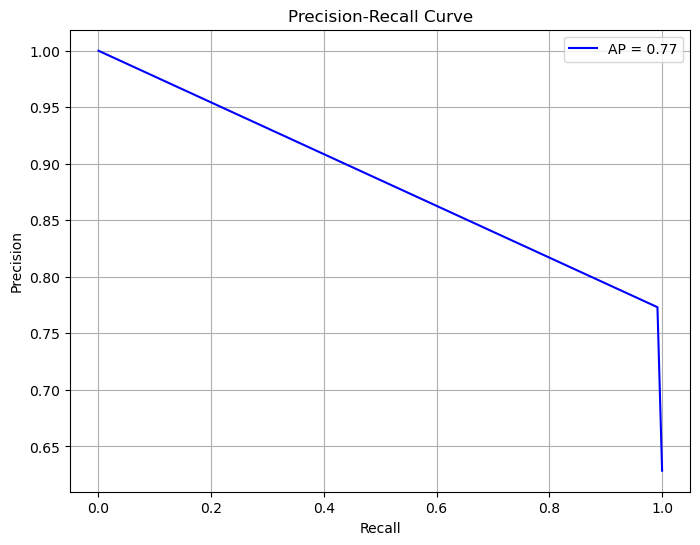

Class 0 (Fake News): Precision=0.97, Recall=0.51, F1 Score=0.67
Class 1 (Real News): Precision=0.77, Recall=0.99, F1 Score=0.87


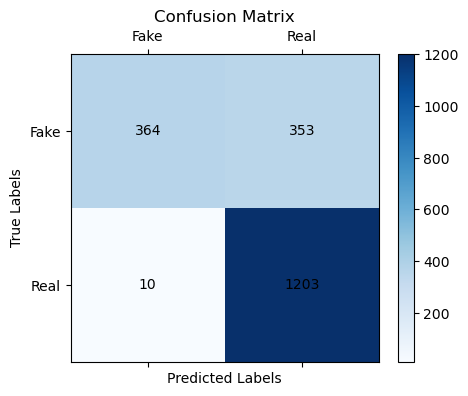

In [36]:
# Hyperparameters
input_dim = 512  # Input dimension of CLIP features
embed_dim = 256  # Embedding dimension
num_fc_layers = 20  # Number of fully connected layers
num_epochs = 18  # Number of epochs
batch_size = 256  # Batch size
learning_rate = 1e-4  # Learning rate
margin = 0.01  # Margin for negative pairs
val_split = 0.2  # Validation data fraction
# Device setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Initialize model
model = TextImageSimilarityModel(input_dim, embed_dim, num_fc_layers).to(device)


model.load_state_dict(torch.load("trained_model_clip.pth"))
# Load and move test data to the device
test_text_features = torch.load('clip_test_text_features.pt').to(device, dtype=torch.float32)
print(f"Test text features shape: {test_text_features.shape}")
test_image_features = torch.load('clip_test_image_features.pt').to(device, dtype=torch.float32)
print(f"Test image features shape: {test_image_features.shape}")
test_labels = torch.load('clip_test_label.pt').to(device, dtype=torch.float32)  # Test labels
print(f"Test labels features shape: {test_labels.shape}")
# Test the model and compute metrics
cos_sim,prediction,true_label = test_model_with_metrics(model,test_text_features,test_image_features,test_labels,margin=margin,batch_size=batch_size,device=device)

In [17]:
cos_sim,prediction,true_label

([tensor([-0.1119, -0.1119, -0.1119, -0.1119, -0.1119, -0.1119, -0.1119, -0.1119,
          -0.1119, -0.1119, -0.1119, -0.1119, -0.1119, -0.1119, -0.1119, -0.1119,
          -0.1119, -0.1119, -0.1119, -0.1119, -0.1119, -0.1119, -0.1119, -0.1119,
          -0.1119, -0.1119, -0.1119, -0.1119, -0.1119, -0.1119, -0.1119, -0.1119,
          -0.1119, -0.1119,  1.0000, -0.1119, -0.1119, -0.1119, -0.1119, -0.1119,
          -0.1119, -0.1119, -0.1119, -0.1119, -0.1119, -0.1119, -0.1119, -0.1119,
          -0.1119, -0.1119, -0.1119, -0.1119, -0.1119, -0.1119, -0.1119, -0.1119,
          -0.1119, -0.1119, -0.1119, -0.1119, -0.1119, -0.1119, -0.1119, -0.1119,
          -0.1119, -0.1119, -0.1119, -0.1119, -0.1119, -0.1119, -0.1119, -0.1119,
          -0.1119, -0.1119, -0.1119, -0.1119, -0.1119, -0.1119, -0.1119, -0.1119,
          -0.1119, -0.1119, -0.1119, -0.1119, -0.1119, -0.1119, -0.1119, -0.1119,
          -0.1119, -0.1119, -0.1119, -0.1119, -0.1119, -0.1119, -0.1119, -0.1119,
          -0.111

In [29]:
torch.mean(cos_sim[4]),prediction[4],true_label[4]

(tensor(0.9973, device='cuda:0'), 0.0, 0.0)

In [61]:
# Load and move test data to the device
test_text_features = torch.load('clip_test_text_features.pt').to(device, dtype=torch.float32)
print(f"Test text features shape: {test_text_features.shape}")
test_image_features = torch.load('clip_test_image_features.pt').to(device, dtype=torch.float32)
print(f"Test image features shape: {test_image_features.shape}")
test_labels = torch.load('clip_test_label.pt').to(device, dtype=torch.float32)  # Test labels
print(f"Test labels features shape: {test_labels.shape}")

n = 500
# Example: Test a single pair (one text and one image)
text_sample = test_text_features[n].unsqueeze(0).to(device)  # Taking the first sample as an example
image_sample = test_image_features[n].unsqueeze(0).to(device)  # Taking the first sample as an example
true_label = test_labels[n].unsqueeze(0).to(device)  # Taking the first sample as an example

# Pass through the model (requires both text and image features)
model.eval()  # Make sure to set the model to evaluation mode

# Get the embeddings
with torch.no_grad():
    sim, text_embedding, image_embedding = model(text_sample, image_sample)

# You can now calculate cosine similarity or other metrics
cosine_similarity = torch.nn.functional.cosine_similarity(text_embedding, image_embedding)
print(f"Cosine similarity between text and image: {cosine_similarity.item()}")
print(f"Cosine similarity between text and image using model: {sim.item()}")

threshold = 0.01
predicted_label = (cosine_similarity > threshold).float()

if true_label > 0:
    print(f"True label is Real")
else:
    print(f"True label is Fake")

if predicted_label > 0:
    print(f"Predicted label is Real")
else:
    print(f"Predicted label is Fake")


Test text features shape: torch.Size([1930, 512])
Test image features shape: torch.Size([1930, 512])
Test labels features shape: torch.Size([1930])
Cosine similarity between text and image: 0.9998825788497925
Cosine similarity between text and image using model: 0.9998825192451477
True label is Fake
Predicted label is Real


C:\Users\swaru\AppData\Local\Temp\ipykernel_46208\1070631546.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_text_features = torch.load('clip_test_text_features.pt'

# Model visulaization

In [9]:
import torch
from torchviz import make_dot
import torch.nn as nn

class TextImageSimilarityModel(nn.Module):
    def __init__(self, input_dim, embed_dim, num_fc_layers=2):
        super(TextImageSimilarityModel, self).__init__()
        # Text branch
        self.text_layers = self._build_fc_layers(input_dim, embed_dim, num_fc_layers)
        
        # Image branch
        self.image_layers = self._build_fc_layers(input_dim, embed_dim, num_fc_layers)
        
    def _build_fc_layers(self, input_dim, embed_dim, num_fc_layers):
        layers = []
        for i in range(num_fc_layers):
            in_dim = input_dim if i == 0 else embed_dim
            out_dim = embed_dim
            layers.append(nn.Linear(in_dim, out_dim))
            if i < num_fc_layers - 1:
                layers.append(nn.ReLU())
        return nn.Sequential(*layers)
    
    def forward(self, text_features, image_features):
        # Process text features
        text_embedding = self.text_layers(text_features)
        text_embedding = nn.functional.normalize(text_embedding, dim=-1)
        
        # Process image features
        image_embedding = self.image_layers(image_features)
        image_embedding = nn.functional.normalize(image_embedding, dim=-1)
        
        # Compute cosine similarity
        similarity = torch.sum(text_embedding * image_embedding, dim=-1)
        return similarity, text_embedding, image_embedding

# Example input dimensions
input_dim = 512
embed_dim = 256

# Instantiate the model
model = TextImageSimilarityModel(input_dim, embed_dim,10)

# Example input features (batch size = 4)
text_features = torch.randn(4, input_dim)
image_features = torch.randn(4, input_dim)

# Forward pass through the model
output = model(text_features, image_features)

# Visualize the model's forward pass graph
make_dot(output[0], params=dict(model.named_parameters())).render("model_architecture", format="png")


'model_architecture.png'

# The New Model ELU Actovation

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TextImageSimilarityModel(nn.Module):
    def __init__(self, input_dim, embed_dim, num_fc_layers=2):
        """
        Initialize the model with configurable number of fully connected layers.
        
        Args:
            input_dim (int): Dimension of the input features (text and image features).
            embed_dim (int): Dimension of the final embedding.
            num_fc_layers (int): Number of fully connected layers.
        """
        super(TextImageSimilarityModel, self).__init__()
        
        # Text branch
        self.text_layers = self._build_fc_layers(input_dim, embed_dim, num_fc_layers)
        
        # Image branch
        self.image_layers = self._build_fc_layers(input_dim, embed_dim, num_fc_layers)
        
    def _build_fc_layers(self, input_dim, embed_dim, num_fc_layers):
        """
        Build a sequence of fully connected layers dynamically.
        """
        layers = []
        for i in range(num_fc_layers):
            in_dim = input_dim if i == 0 else embed_dim
            out_dim = embed_dim
            layers.append(nn.Linear(in_dim, out_dim))
            if i < num_fc_layers - 1:  # No activation on the final layer
                layers.append(nn.ELU())
        return nn.Sequential(*layers)
    
    def forward(self, text_features, image_features):
        # Process text features
        text_embedding = self.text_layers(text_features)
        text_embedding = F.normalize(text_embedding, dim=-1)
        
        # Process image features
        image_embedding = self.image_layers(image_features)
        image_embedding = F.normalize(image_embedding, dim=-1)
        
        # Compute cosine similarity
        similarity = torch.sum(text_embedding * image_embedding, dim=-1)
        return similarity, text_embedding, image_embedding

C:\Users\swaru\AppData\Local\Temp\ipykernel_56456\196983635.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  text_features = torch.load('clip_train_text_features.pt').to

Train text features shape: torch.Size([14254, 512])
Train image features shape: torch.Size([14254, 512])
Train labels features shape: torch.Size([14254])


C:\Users\swaru\AppData\Local\Temp\ipykernel_56456\196983635.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image_features = torch.load('clip_train_image_features.pt').

Epoch 1/18, Train Loss: 0.6095, Train Accuracy: 0.5887, Val Loss: 0.1085, Val Accuracy: 0.9330
Epoch 2/18, Train Loss: 0.0750, Train Accuracy: 0.9570, Val Loss: 0.0675, Val Accuracy: 0.9565
Epoch 3/18, Train Loss: 0.0634, Train Accuracy: 0.9647, Val Loss: 0.0654, Val Accuracy: 0.9544
Epoch 4/18, Train Loss: 0.0444, Train Accuracy: 0.9753, Val Loss: 0.0439, Val Accuracy: 0.9754
Epoch 5/18, Train Loss: 0.0436, Train Accuracy: 0.9740, Val Loss: 0.0366, Val Accuracy: 0.9782
Epoch 6/18, Train Loss: 0.0379, Train Accuracy: 0.9784, Val Loss: 0.0361, Val Accuracy: 0.9779
Epoch 7/18, Train Loss: 0.0363, Train Accuracy: 0.9788, Val Loss: 0.0364, Val Accuracy: 0.9772
Epoch 8/18, Train Loss: 0.0349, Train Accuracy: 0.9792, Val Loss: 0.0361, Val Accuracy: 0.9775
Epoch 9/18, Train Loss: 0.0353, Train Accuracy: 0.9793, Val Loss: 0.0364, Val Accuracy: 0.9772
Epoch 10/18, Train Loss: 0.0361, Train Accuracy: 0.9791, Val Loss: 0.0364, Val Accuracy: 0.9775
Epoch 11/18, Train Loss: 0.0352, Train Accuracy: 

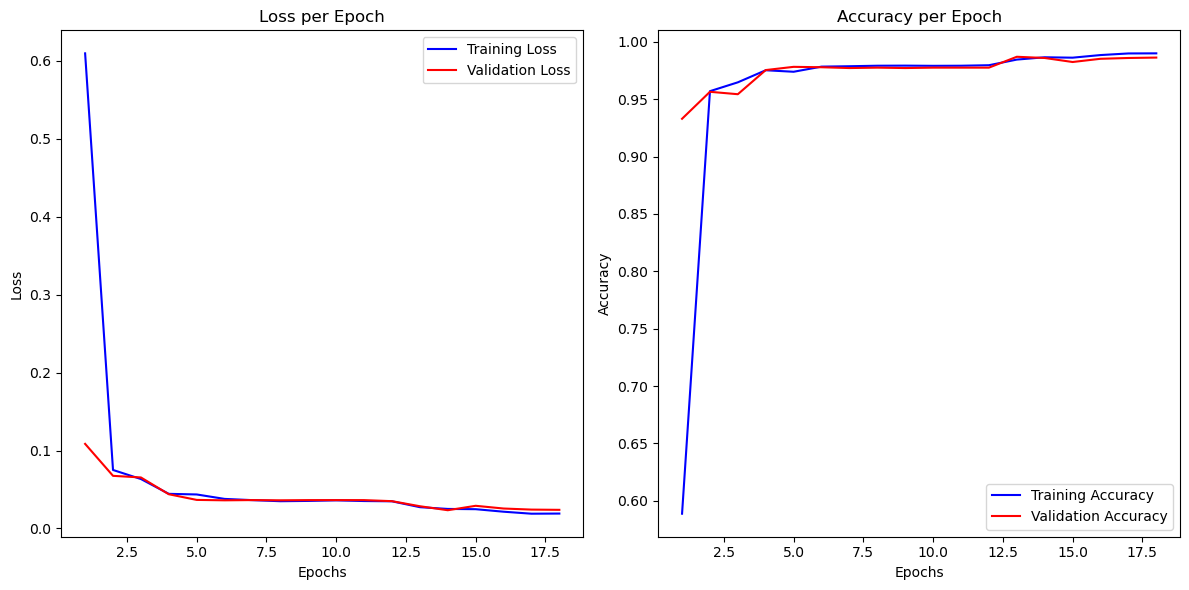

Test text features shape: torch.Size([1930, 512])
Test image features shape: torch.Size([1930, 512])
Test labels features shape: torch.Size([1930])
Test Loss: 0.9228
Precision: 0.7551
Recall: 0.7601
F1 Score: 0.7576
Accuracy: 0.6943
Class 0 (Fake News): Precision=0.59, Recall=0.58, F1 Score=0.59
Class 1 (Real News): Precision=0.76, Recall=0.76, F1 Score=0.76


C:\Users\swaru\AppData\Local\Temp\ipykernel_56456\196983635.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_text_features = torch.load('clip_test_text_features.pt'

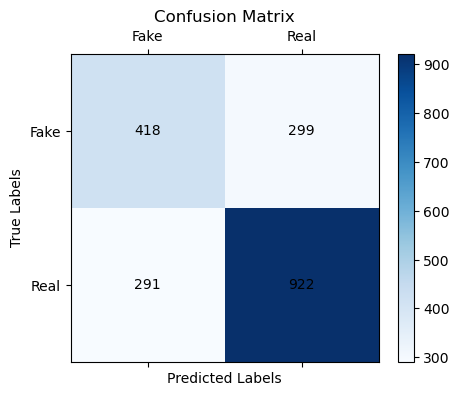

In [10]:
# Define the necessary imports
import torch

# Hyperparameters
input_dim = 512  # Input dimension of CLIP features
embed_dim = 256  # Embedding dimension
num_fc_layers = 20  # Number of fully connected layers
num_epochs = 18  # Number of epochs
batch_size = 256  # Batch size
learning_rate = 1e-4  # Learning rate
margin = 0.01  # Margin for negative pairs
val_split = 0.2  # Validation data fraction

# Device setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load and move data to the device
text_features = torch.load('clip_train_text_features.pt').to(device, dtype=torch.float32)
print(f"Train text features shape: {text_features.shape}")
image_features = torch.load('clip_train_image_features.pt').to(device, dtype=torch.float32)
print(f"Train image features shape: {image_features.shape}")
labels = torch.load('clip_train_label.pt').to(device, dtype=torch.float32)  # Binary labels: 1 for positive pairs, 0 for negative pairs
print(f"Train labels features shape: {labels.shape}")

# Initialize model
model = TextImageSimilarityModel(input_dim, embed_dim, num_fc_layers).to(device)


# Train the model
trained_model = train_model_with_plot(model,text_features,image_features,labels,num_epochs=num_epochs,learning_rate=learning_rate,margin=margin,batch_size=batch_size,val_split=val_split,device=device)
# Load and move test data to the device
test_text_features = torch.load('clip_test_text_features.pt').to(device, dtype=torch.float32)
print(f"Test text features shape: {test_text_features.shape}")
test_image_features = torch.load('clip_test_image_features.pt').to(device, dtype=torch.float32)
print(f"Test image features shape: {test_image_features.shape}")
test_labels = torch.load('clip_test_label.pt').to(device, dtype=torch.float32)  # Test labels
print(f"Test labels features shape: {test_labels.shape}")
# Test the model and compute metrics
test_model_with_metrics(trained_model,test_text_features,test_image_features,test_labels,margin=margin,batch_size=batch_size,device=device)

C:\Users\swaru\AppData\Local\Temp\ipykernel_56456\3592963336.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  text_features = torch.load('clip_train_text_features.pt').t

Train text features shape: torch.Size([14254, 512])
Train image features shape: torch.Size([14254, 512])
Train labels features shape: torch.Size([14254])
Epoch 1/18, Train Loss: 0.6437, Train Accuracy: 0.5626, Val Loss: 0.1381, Val Accuracy: 0.9172
Epoch 2/18, Train Loss: 0.0872, Train Accuracy: 0.9483, Val Loss: 0.0694, Val Accuracy: 0.9582
Epoch 3/18, Train Loss: 0.0588, Train Accuracy: 0.9664, Val Loss: 0.0592, Val Accuracy: 0.9667
Epoch 4/18, Train Loss: 0.0504, Train Accuracy: 0.9719, Val Loss: 0.0558, Val Accuracy: 0.9677
Epoch 5/18, Train Loss: 0.0472, Train Accuracy: 0.9739, Val Loss: 0.0519, Val Accuracy: 0.9723
Epoch 6/18, Train Loss: 0.0459, Train Accuracy: 0.9747, Val Loss: 0.0487, Val Accuracy: 0.9737
Epoch 7/18, Train Loss: 0.0420, Train Accuracy: 0.9774, Val Loss: 0.0339, Val Accuracy: 0.9849
Epoch 8/18, Train Loss: 0.0302, Train Accuracy: 0.9859, Val Loss: 0.0328, Val Accuracy: 0.9853
Epoch 9/18, Train Loss: 0.0266, Train Accuracy: 0.9876, Val Loss: 0.0335, Val Accuracy

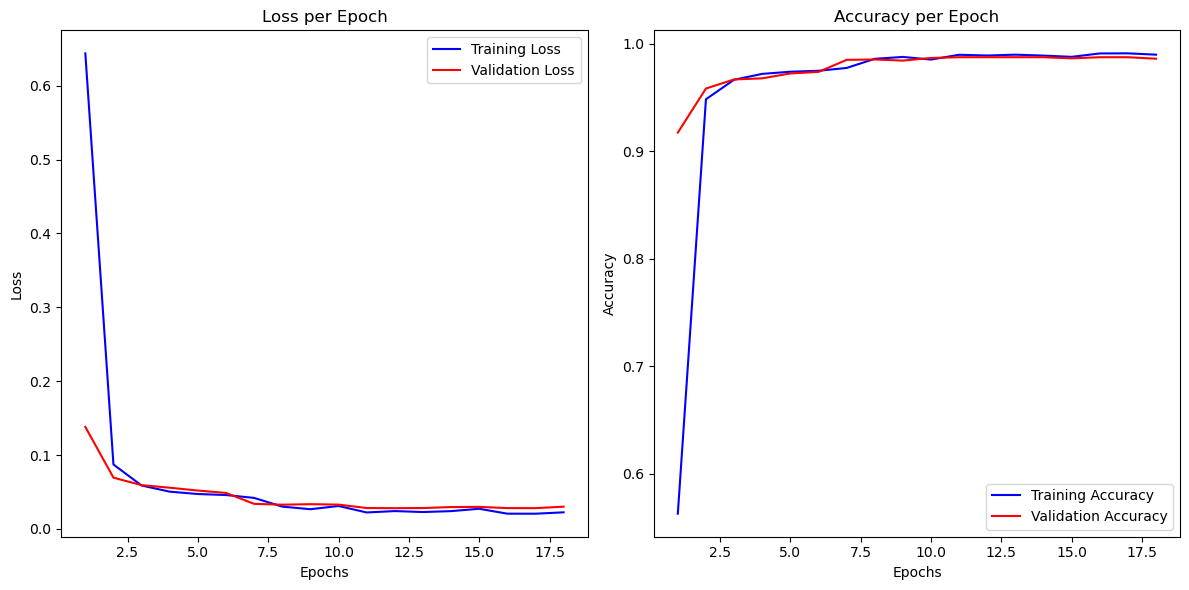

Test text features shape: torch.Size([1930, 512])
Test image features shape: torch.Size([1930, 512])
Test labels features shape: torch.Size([1930])
Test Loss: 0.3959
Precision: 0.7710
Recall: 0.9324
F1 Score: 0.8440
Accuracy: 0.7834
Class 0 (Fake News): Precision=0.82, Recall=0.53, F1 Score=0.65
Class 1 (Real News): Precision=0.77, Recall=0.93, F1 Score=0.84


C:\Users\swaru\AppData\Local\Temp\ipykernel_56456\3592963336.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_text_features = torch.load('clip_test_text_features.pt

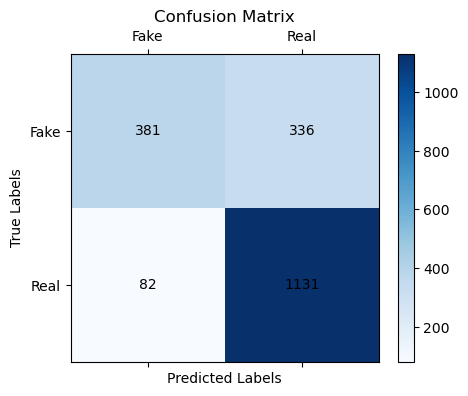

In [11]:
# Define the necessary imports
import torch

# Hyperparameters
input_dim = 512  # Input dimension of CLIP features
embed_dim = 256  # Embedding dimension
num_fc_layers = 20  # Number of fully connected layers
num_epochs = 18  # Number of epochs
batch_size = 256  # Batch size
learning_rate = 1e-4  # Learning rate
margin = 0.009  # Margin for negative pairs
val_split = 0.2  # Validation data fraction

# Device setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load and move data to the device
text_features = torch.load('clip_train_text_features.pt').to(device, dtype=torch.float32)
print(f"Train text features shape: {text_features.shape}")
image_features = torch.load('clip_train_image_features.pt').to(device, dtype=torch.float32)
print(f"Train image features shape: {image_features.shape}")
labels = torch.load('clip_train_label.pt').to(device, dtype=torch.float32)  # Binary labels: 1 for positive pairs, 0 for negative pairs
print(f"Train labels features shape: {labels.shape}")

# Initialize model
model = TextImageSimilarityModel(input_dim, embed_dim, num_fc_layers).to(device)


# Train the model
trained_model = train_model_with_plot(model,text_features,image_features,labels,num_epochs=num_epochs,learning_rate=learning_rate,margin=margin,batch_size=batch_size,val_split=val_split,device=device)
# Load and move test data to the device
test_text_features = torch.load('clip_test_text_features.pt').to(device, dtype=torch.float32)
print(f"Test text features shape: {test_text_features.shape}")
test_image_features = torch.load('clip_test_image_features.pt').to(device, dtype=torch.float32)
print(f"Test image features shape: {test_image_features.shape}")
test_labels = torch.load('clip_test_label.pt').to(device, dtype=torch.float32)  # Test labels
print(f"Test labels features shape: {test_labels.shape}")
# Test the model and compute metrics
test_model_with_metrics(trained_model,test_text_features,test_image_features,test_labels,margin=margin,batch_size=batch_size,device=device)